In [23]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error as MAE,
    mean_squared_error as RMSE,
    r2_score as R2,
)
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import GridSearchCV, ParameterGrid, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from tensorflow import keras
from plot import (
    model_list,
    pred_plot,
    err_plot,
)
from model import (
    load_data,
    train_and_test,
    hyperparam_graph,
    hyperparam_plot,
    make_grid,
    eval_model,
    tv_split_path,
    test_split_path,
    PickleableKerasRegressor,
    HistoryKerasRegressor,
    reload_model,
    compute_metrics,
    dnn_gen,
    plot_net_training_curves,
)

resources = "resources/"
metadata_path = os.path.join(resources, "fdk_site_info.csv")
predictions_path = os.path.join(resources, "predictions.csv.gz")
results_path = os.path.join(resources, "results.csv")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Data modeling

We will now build and tune six models. Let us start by loading the data processed in the EDA:

In [24]:
X_tv, y_tv = load_data(tv_split_path)
X_test, y_test = load_data(test_split_path)

Loading resources/tv_split.csv.gz...
(115729, 22)
(115729, 1)
Loading resources/test_split.csv.gz...
(49599, 22)
(49599, 1)


## Hypertuning strategy

- We use grid search with cross validation to tune the hyperparameters of our models.
Because we are tuning many models, we use only 3 splits (unless for models that are very quick to fit).
- We use `neg_mean_absolute_error` as metric for selecting the best hyperparameters.
This is because we prefer emphasizing MAE rather than the squared errors for more robustness to bias.
As a result, the score in the plot is $-MAE$.
- When there are many hyperparameters, we tune half in a first run, then tune the remaining ones in a second run (using the best values for the other parameters selected from the first run).
- For SVR models, the fitting time is too large to work with the whole test/validate set.
Therefore, we tune some parameters using only 5000 test samples.
Note that refit uses all the available data anyways.
- We use shuffle split strategy instead of KFold because we want to be able to configure the size of the training data as explained above.
- For DNN, we tune the parameters using 5 epochs only to keep training time reasonably short.
We fit the model a last time using a large number of epochs and early stopping.

## Baseline

We use the mean as baseline.

In [3]:
baseline = DummyRegressor(strategy="mean")
train_and_test("baseline", baseline, X_tv, y_tv, X_test, y_test)
pass

Total training time: 0.0s
----
Predicting train...
Prediction time: 0.0s
Score (train): 0.0
MAE (train): 2.85
RMSE (train): 11.63
----
Predicting test...
Prediction time: 0.0s
Score (test): -0.0
MAE (test): 2.84
RMSE (test): 11.66


## Simple models

To get started, we build two simple models using only 2 parameters:
- `ridge_2p_rs`: A linear regression using only remote sensed data (`FPAR` and `LAI`)
- `knn_2p_pca`: A kNN regression using the two main principal components from local environmental variables only (i.e. excluding `FPAR`, `LAI` and `apar`)

In [4]:
# Remote sensed features
rs_features = ["LAI", "FPAR"]

# Local features
local_features = [f for f in X_tv.columns.values if f not in ["LAI", "FPAR", "apar"]]

### Linear model with remote-sensed data only

We build a first model which uses only remote sensed data.
It is a simple linear regression on two features only.
We use the Ridge regression to benefit from its $L_2$ regularization.

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Total training time: 34.33s
Mean fit time: 0.12s
----
Predicting train...
Prediction time: 0.07s
Score (train): 0.6
MAE (train): 1.54
RMSE (train): 4.66
----
Predicting test...
Prediction time: 0.04s
Score (test): 0.59
MAE (test): 1.55
RMSE (test): 4.76


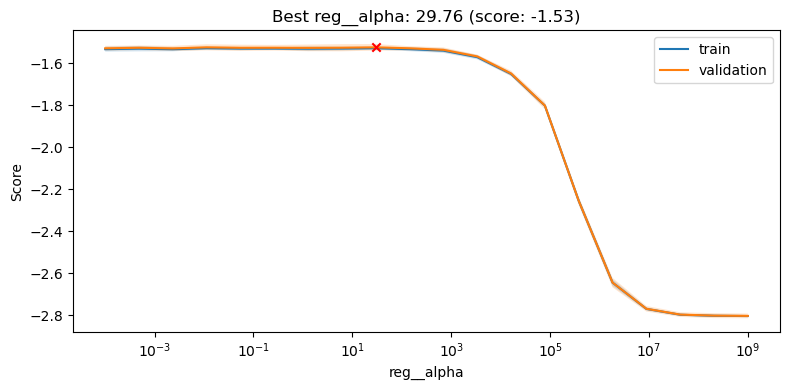

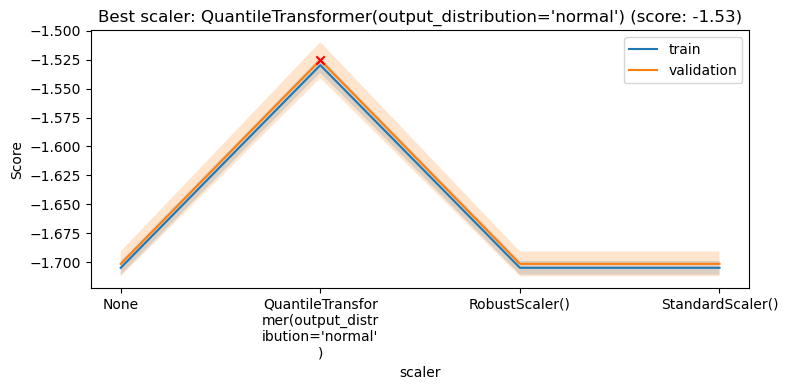

In [7]:
grid = make_grid(
    [
        None,
        StandardScaler(),
        RobustScaler(),
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__alpha": np.logspace(-4, 9, num=20),
    },
)
model, _, _, _, _, _ = eval_model(
    "ridge_2p_rs",
    Ridge(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    features=rs_features,
    n_splits=10,
)
hyperparam_graph(model, "reg__alpha", xlog=True)
hyperparam_graph(model, "scaler")

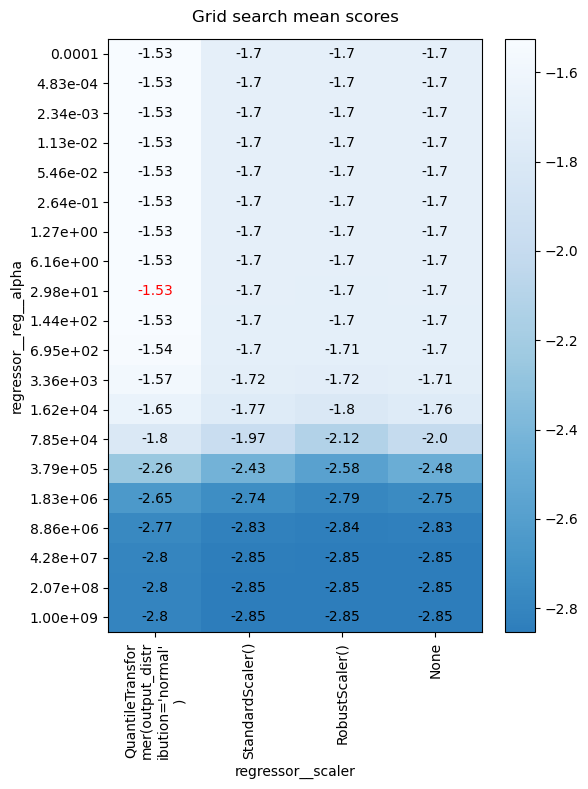

In [8]:
hyperparam_plot(model, ["scaler", "reg__alpha"], figsize=(6, 8))

Notes:
- It seems that the model does not seem to require regularization at all.
The generalization looks excellent since both train and validation curves are very close to each other and the standard deviation is close to 0.
- As expected, given the very biased distributions of our data, the quantile transformer performs best.
We will keep it for the next model as well.

### Linear and kNN models on local variables (PCA projection)

#### PCA Scree plot

We want to extract two components using PCA on local features only.
Let us plot the scree plot to see how much explained variance we might expect:

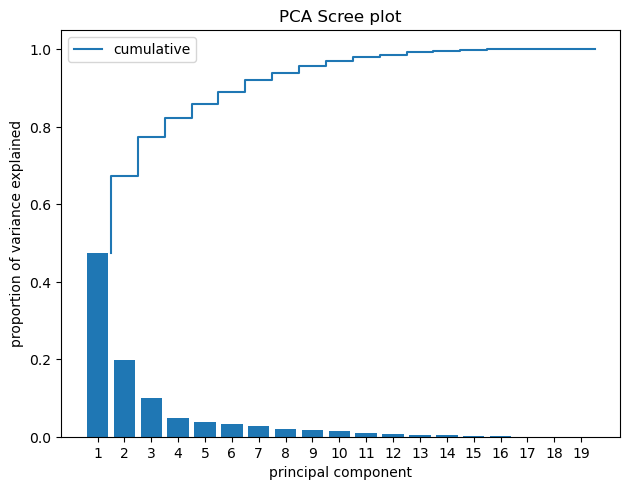

In [11]:
scaler = QuantileTransformer(output_distribution="normal")
X_rescaled = scaler.fit_transform(X_tv[local_features])
pca = PCA()
pca.fit(X_rescaled, y=None)
pve = pca.explained_variance_ratio_

xcor = np.arange(1, len(pve) + 1)
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor + 0.5,  # 1.5,2.5,..,n_components+0.5
    pve_cumsum,  # Cumulative sum
    label="cumulative",
)

# Add labels
plt.xlabel("principal component")
plt.ylabel("proportion of variance explained")
plt.legend()
plt.tight_layout()
plt.title("PCA Scree plot")
plt.show()

From the scree plot, close to 70% of the variance can be explained with the two first components only.

Out of curiosity, we also observe how the score of a linear regression would improve as we add the components one by one:

Fitting 3 folds for each of 76 candidates, totalling 228 fits
Total training time: 128.94s
Mean fit time: 1.45s
----
Predicting train...
Prediction time: 0.52s
Score (train): 0.75
MAE (train): 1.18
RMSE (train): 2.91
----
Predicting test...
Prediction time: 0.25s
Score (test): 0.74
MAE (test): 1.2
RMSE (test): 2.99


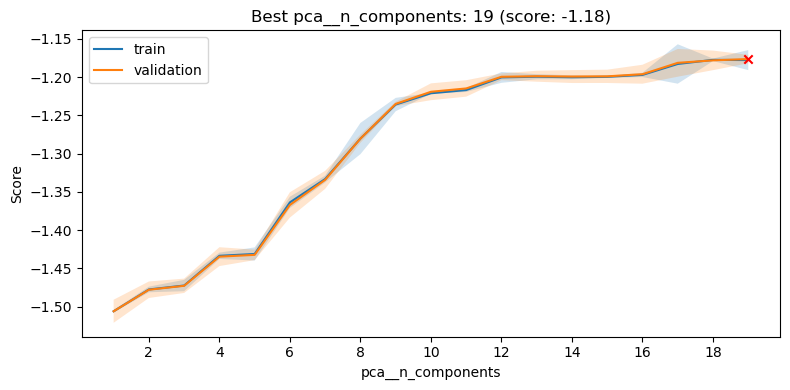

In [12]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__alpha": np.logspace(-2, 2, num=4),
        "pca__n_components": range(1, len(local_features) + 1),
    },
)
model, _, _, _, _, _ = eval_model(
    None, Ridge(), grid, X_tv, y_tv, X_test, y_test, features=local_features, pca=True
)
hyperparam_graph(model, "pca__n_components", xint=True)

As indicated by the scree plot, we can see that the first 12 components seem to contain most of the information usable by a linear regression.

#### kNN

Let us build a kNN model using only two components. The reason for this is to avoid dimensionality curse:

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Total training time: 193.78s
Mean fit time: 1.48s
----
Predicting train...
Prediction time: 3.92s
Score (train): 0.66
MAE (train): 1.37
RMSE (train): 3.93
----
Predicting test...
Prediction time: 1.77s
Score (test): 0.65
MAE (test): 1.39
RMSE (test): 4.04


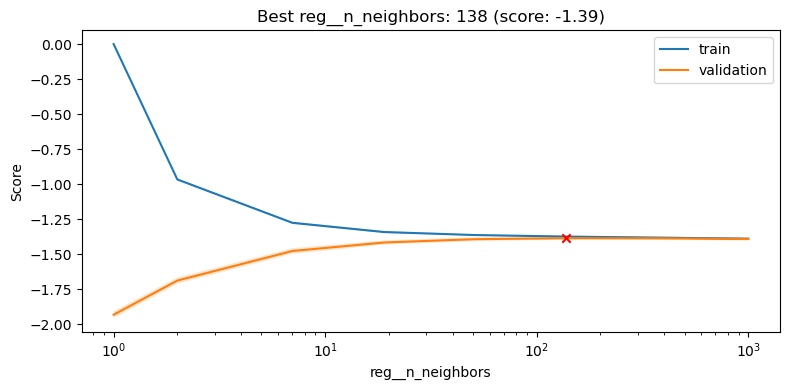

In [8]:
grid = make_grid(
    [QuantileTransformer(output_distribution="normal")],
    {
        "reg__n_neighbors": np.logspace(0, 3, num=8, dtype=int),
        "reg__weights": ["uniform"],
        "pca__n_components": [2],
    },
)
model = eval_model(
    "knn_2p_pca",
    KNeighborsRegressor(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    features=local_features,
    pca=True,
    n_splits=10,
)
hyperparam_graph(model, "reg__n_neighbors", xlog=True)

Notes:
- With two principal components, kNN outperforms `ridge_2p_rs`, but also the linear regression with the 6 first principal components!
- As for the linear model, it is striking to see such a good match between the test and train curves.

## Full models

We now turn ourselves to models using all the available features ("full" models).

### Linear regression

We use a Ridge regression for its $L_2$ regularization.

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Total training time: 108.94s
Mean fit time: 0.3s
----
Predicting train...
Prediction time: 0.58s
Score (train): 0.8
MAE (train): 1.06
RMSE (train): 2.37
----
Predicting test...
Prediction time: 0.26s
Score (test): 0.79
MAE (test): 1.07
RMSE (test): 2.43


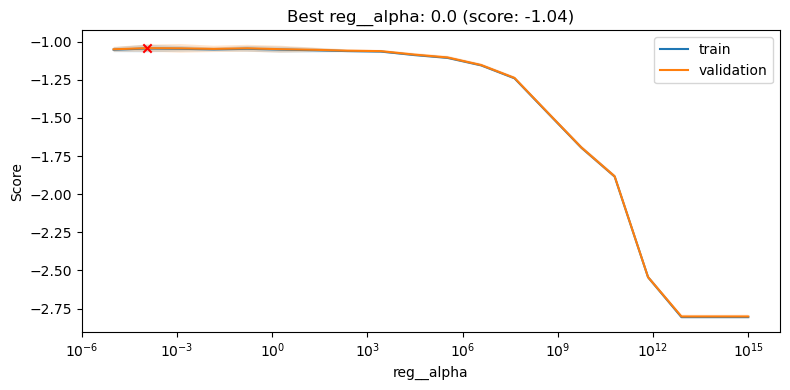

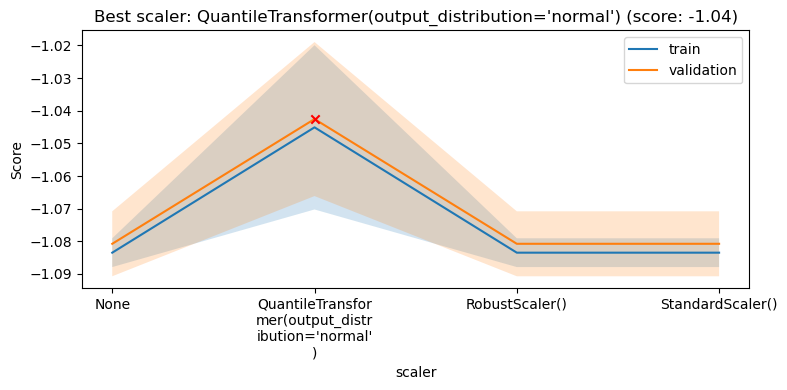

In [13]:
grid = make_grid(
    [
        None,
        StandardScaler(),
        RobustScaler(),
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__alpha": np.logspace(-5, 15, num=20),
    },
)
model, _, _, _, _, _ = eval_model(
    "ridge_full", Ridge(), grid, X_tv, y_tv, X_test, y_test, n_splits=10
)
hyperparam_graph(model, "reg__alpha", xlog=True)
hyperparam_graph(model, "scaler")

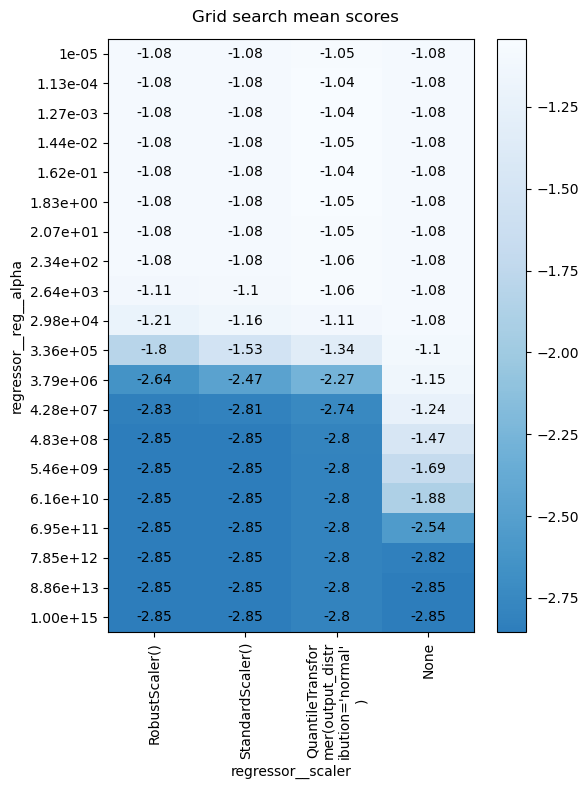

In [14]:
hyperparam_plot(model, ["scaler", "reg__alpha"], figsize=(6, 8))

Notes:
- The linear model with all the features outperforms the previous models.
- The generalization is very good (marginal gap between test and validate curves, and very low standard deviation).
- We note that, this time, the regularization factor needs to be quite high compared to the lack of regularization needed in the 2-parameter linear model.
- The quantile scaler is marginally better than the others.
We will use it for the remaining of the models.

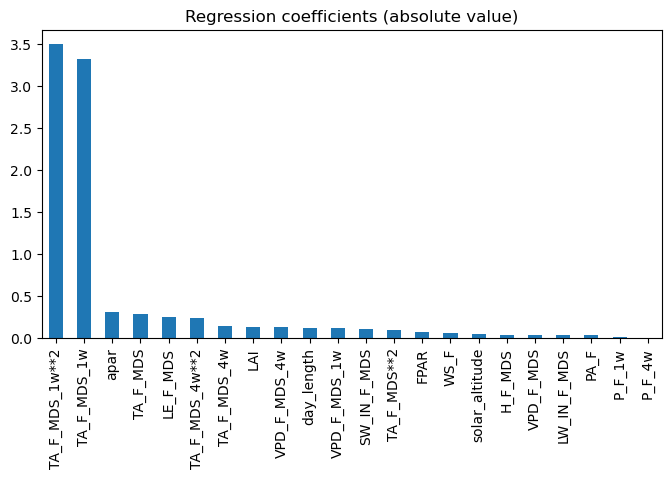

In [38]:
plt.figure(figsize=(8, 4))
pd.Series(
    np.abs(model.best_estimator_.regressor_.named_steps.reg.coef_),
    index=X_tv.columns.values,
).sort_values(ascending=False).plot.bar()
plt.title("Regression coefficients (absolute value)")
plt.show()

### Random forest

We now build a random forest model.
Because there are many parameters, we tune a first batch now and we'll tune the rest in a second pass.

Notes:
- We set a slightly aggressive value for `min_samples_leaf` to ensure that the tree will not overfit and grow very large in size.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Total training time: 1665.19s
Mean fit time: 91.71s
----
Predicting train...
Prediction time: 3.36s
Score (train): 0.94
MAE (train): 0.56
RMSE (train): 0.75
----
Predicting test...
Prediction time: 1.48s
Score (test): 0.89
MAE (test): 0.73
RMSE (test): 1.24


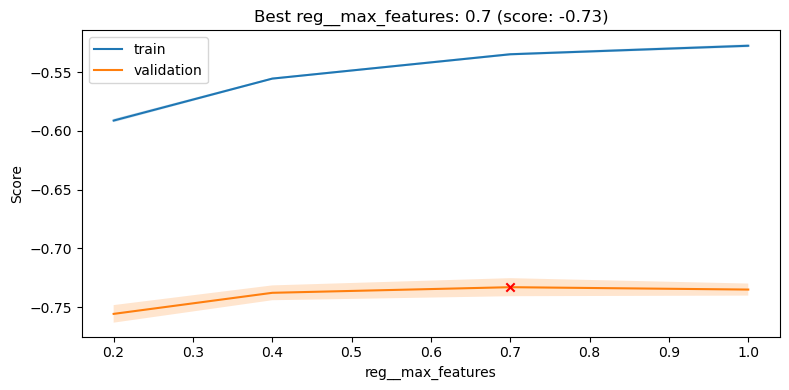

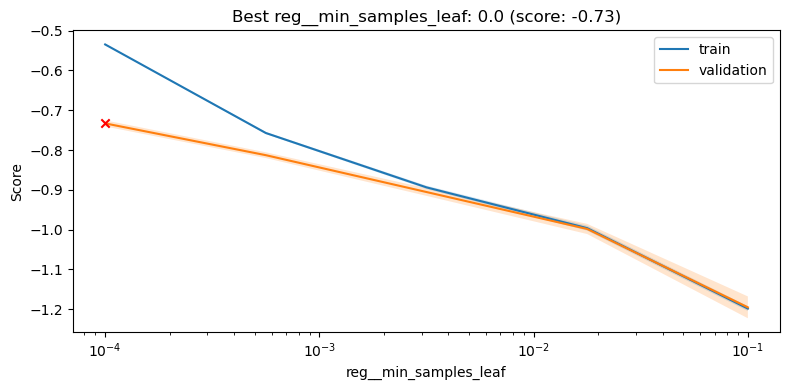

In [10]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n_estimators": [100],
        "reg__max_features": [0.2, 0.4, 0.7, 1.0],
        "reg__min_samples_leaf": np.logspace(-4, -1, num=5),
    },
)
model = eval_model(
    "rf_full", RandomForestRegressor(), grid, X_tv, y_tv, X_test, y_test, n_splits=3
)
hyperparam_graph(model, "reg__max_features", xlog=False)
hyperparam_graph(model, "reg__min_samples_leaf", xlog=True)

Notes:
- Random forests outperforms the other models so far, but it is prone to overfitting.
- Increasing the number of features slightly improves the performance, at the cost of computation time and overfitting.
- Decreasing the minimum leaf size obviously improves the precision (since it affects directly the depth of the tree), but at the expanse of the fitting time, and overfitting:
we can see that the curves start to diverge for values less than 0.001 and we can actually see that there is an important gap between the train and test sets metrics indicating that the refitted model definitely overfitted.
We will therefore settle on 0.001.

Let us now try different numbers of trees:

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Total training time: 727.76s
Mean fit time: 96.94s
----
Predicting train...
Prediction time: 2.61s
Score (train): 0.87
MAE (train): 0.82
RMSE (train): 1.51
----
Predicting test...
Prediction time: 1.08s
Score (test): 0.86
MAE (test): 0.86
RMSE (test): 1.67


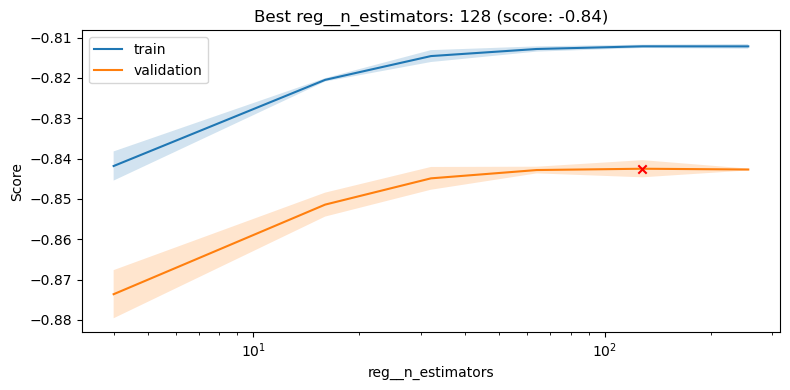

In [11]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n_estimators": [4, 16, 32, 64, 128, 256],
        "reg__max_features": [0.6],
        "reg__min_samples_leaf": [0.001],
    },
)
model = eval_model(
    "rf_full", RandomForestRegressor(), grid, X_tv, y_tv, X_test, y_test, n_splits=3
)
hyperparam_graph(model, "reg__n_estimators", xlog=True)

Past 64 trees, the number of trees does not seem to improve the performance or the robustness of the model.
We will refit the model with this value to save disk space:

In [12]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n_estimators": [64],
        "reg__max_features": [0.6],
        "reg__min_samples_leaf": [0.001],
    },
)
model = eval_model(
    "rf_full", RandomForestRegressor(), grid, X_tv, y_tv, X_test, y_test, n_splits=1
)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Total training time: 154.9s
Mean fit time: 63.39s
----
Predicting train...
Prediction time: 1.55s
Score (train): 0.87
MAE (train): 0.82
RMSE (train): 1.52
----
Predicting test...
Prediction time: 0.64s
Score (test): 0.86
MAE (test): 0.86
RMSE (test): 1.67


Let us get an idea of the shape of the trees:

In [13]:
rf = model.best_estimator_.regressor_.named_steps.reg
tree_depth = pd.Series([tree.get_depth() for tree in rf.estimators_], name="depth")
tree_leaves = pd.Series([tree.get_n_leaves() for tree in rf.estimators_], name="leaves")
print(f"Average tree depth: {int(tree_depth.mean())}")
print(f"Average leaf count: {int(tree_leaves.mean())}")

Average tree depth: 16
Average leaf count: 482


We can see on the diagram below, showing the feature importance, that the model relies mainly on the past week air temperature average (and its square) followed by the Leaf Area Index and latent heat flux and the two remote sensed features.
The standard deviations are fairly large indicating a large variation in the trees.
It is noteworthy that the model did not place any importance in the precipitation.

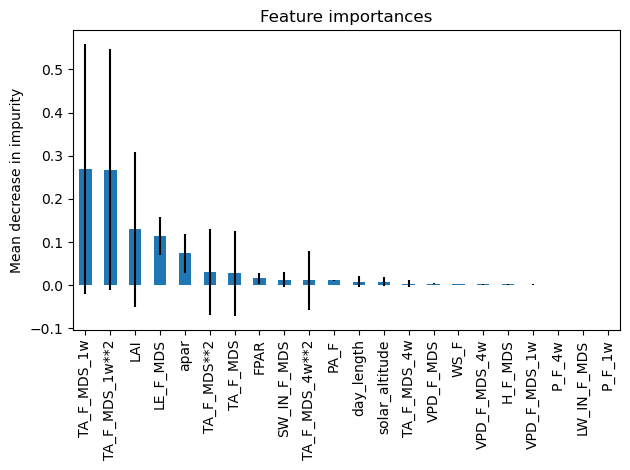

In [14]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_tv.columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
importance_df = pd.DataFrame(
    {"importance": forest_importances, "std": std}, index=X_tv.columns
)
importance_df.sort_values("importance", ascending=False, inplace=True)
fig, ax = plt.subplots()
importance_df["importance"].plot.bar(yerr=importance_df["std"], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### SVR

We build a SVR model.
Because of the large fitting time, we limit the test folds to 5000 samples in size.

Fitting 3 folds for each of 49 candidates, totalling 147 fits
Total training time: 13126.12s
Mean fit time: 7.43s
----
Predicting train...
Prediction time: 1131.06s
Score (train): 0.9
MAE (train): 0.68
RMSE (train): 1.13
----
Predicting test...
Prediction time: 490.56s
Score (test): 0.89
MAE (test): 0.73
RMSE (test): 1.25


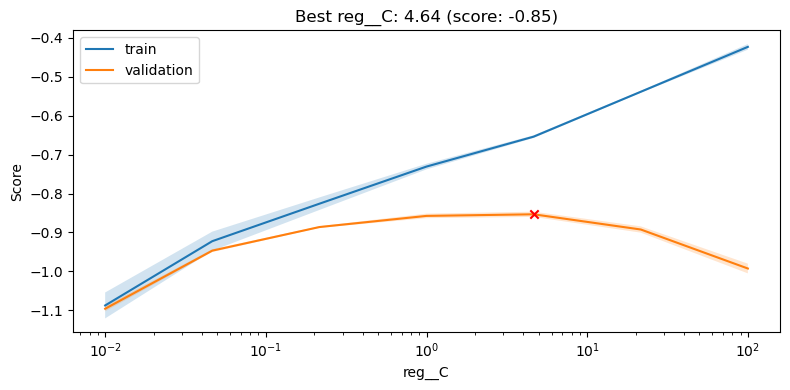

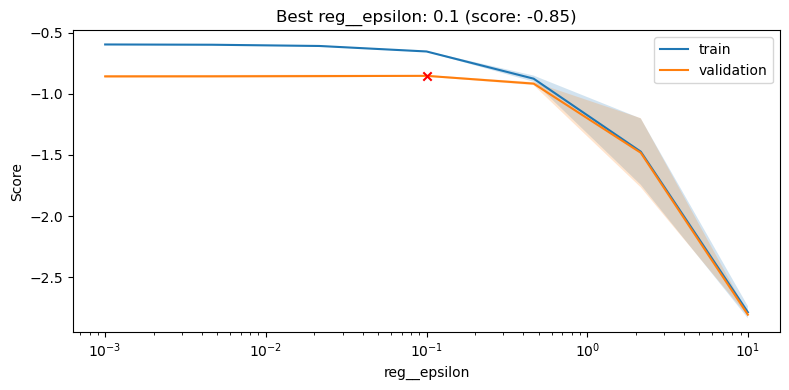

In [15]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__C": np.logspace(-2, 2, num=7),
        "reg__epsilon": np.logspace(-3, 1, num=7),
        "reg__kernel": ["rbf"],
    },
)
model = eval_model(
    "svr_full", SVR(), grid, X_tv, y_tv, X_test, y_test, train_size=5000, n_splits=3
)
hyperparam_graph(model, "reg__C", xlog=True)
hyperparam_graph(model, "reg__epsilon", xlog=True)

Notes:
- SVR performs even better than the Random Forest model, but is also prone to overfitting.
- We clearly see that the model starts overfitting for $C > 0.1$ (inverse regularization) and $\epsilon < 0.5$ as the gap between the training and validation curves increases.
- The model is extremely slow at both fitting and predicting.

We now try the linear kernel and tune gamma:

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Total training time: 573.11s
Mean fit time: 2.15s
----
Predicting train...
Prediction time: 522.28s
Score (train): 0.88
MAE (train): 0.8
RMSE (train): 1.43
----
Predicting test...
Prediction time: 224.31s
Score (test): 0.87
MAE (test): 0.81
RMSE (test): 1.5


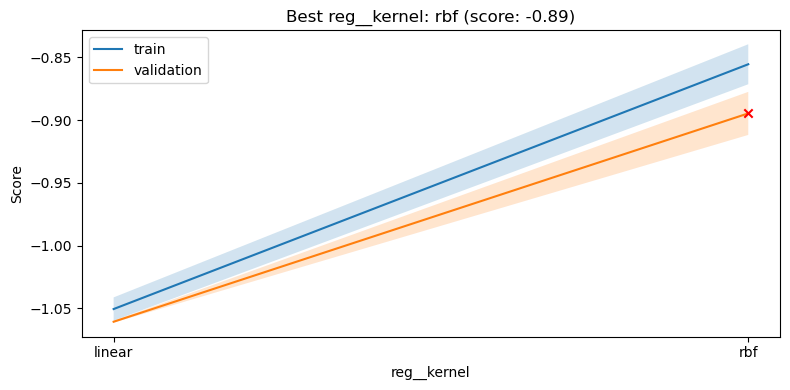

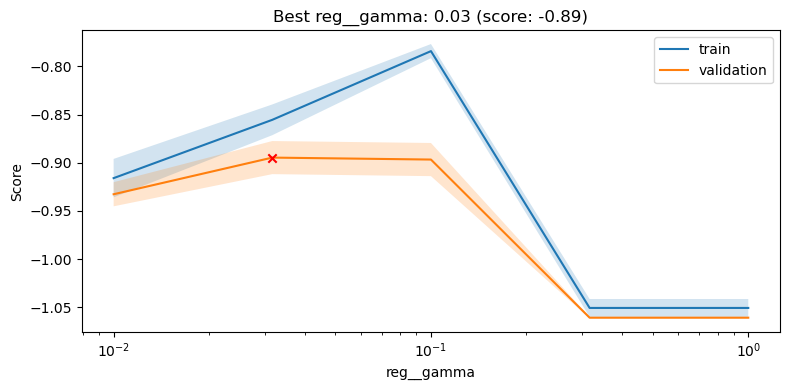

In [16]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__C": [0.5],
        "reg__epsilon": [0.3],
        "reg__kernel": ["rbf", "linear"],
        "reg__gamma": np.logspace(-2, 0, num=5),
    },
)
model = eval_model("svr_full", SVR(), grid, X_tv, y_tv, X_test, y_test, train_size=5000)
hyperparam_graph(model, "reg__kernel")
hyperparam_graph(model, "reg__gamma", xlog=True)

Notes:
- The RBF kernel brings better results, albeit slightly overfitting compared to the linear kernel.
- We get a slightly lower score than at the previous grid search, but it seems that those settings lead to a less overfitting model.
- The prediction times are outrageous!

### DNN

We build a dense neural network consisting of a variable number of hidden layers, all of the same size and including optionally a dropout layer and $L_2$ regularization.
Finally, a single neuron layer is used as regressor.

Let us start with a single hidden layer. Because of the large fitting time, we limit to 5 epochs.

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Total training time: 614.14s
Mean fit time: 10.79s
----
Predicting train...
Prediction time: 2.44s
Score (train): 0.85
MAE (train): 0.88
RMSE (train): 1.73
----
Predicting test...
Prediction time: 1.09s
Score (test): 0.85
MAE (test): 0.9
RMSE (test): 1.8


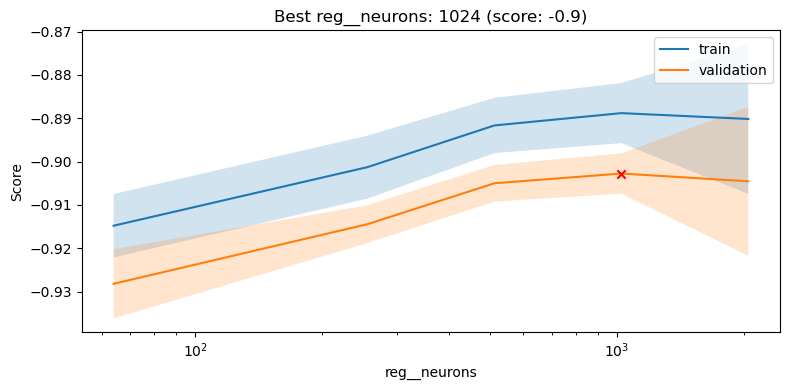

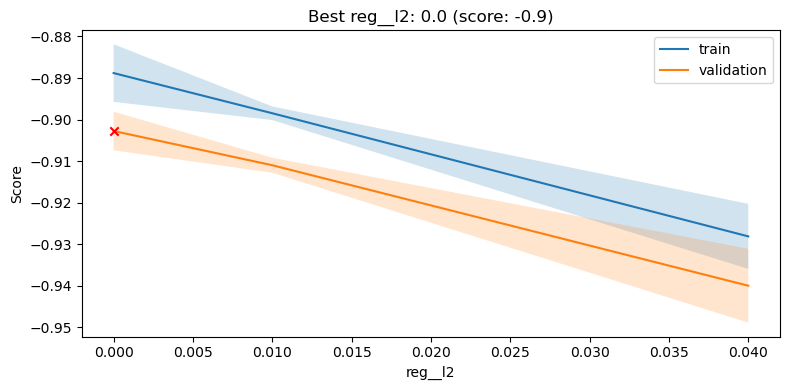

In [17]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__hidden": [1],
        "reg__neurons": [64, 256, 512, 1024, 2048],
        "reg__dropout": [0],
        "reg__l2": [0, 0.01, 0.04],
        "reg__epochs": [5],
    },
)

# We use a KerasRegressor to make a Keras model fit in the scikit estimator API
# We extended it to add support for pickling (cf shared.py)
# model_fun is the model builder function also implemented in shared.py because it needed to be shared with other notebooks.
reg = PickleableKerasRegressor(dnn_gen, shuffle=True, verbose=0)
model = eval_model("dnn_full", reg, grid, X_tv, y_tv, X_test, y_test, n_jobs=1)
hyperparam_graph(model, "reg__neurons", xlog=True)
hyperparam_graph(model, "reg__l2", xlog=False)

Notes:
- The performance seems maximal with 1000 neurons. Note that the apparent large standard deviation is an artifact (they correspond to runs with high regularization).
- Too high regularization leads to underfitting.
- The performance is already good, but it will get better with more epochs.

We proceed with a two hidden layer network including optional dropout.
We increase the number of epochs slightly because a deeper network will be slower to train.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Total training time: 3231.55s
Mean fit time: 78.09s
----
Predicting train...
Prediction time: 7.76s
Score (train): 0.87
MAE (train): 0.83
RMSE (train): 1.54
----
Predicting test...
Prediction time: 3.17s
Score (test): 0.86
MAE (test): 0.84
RMSE (test): 1.61
Could not send push notification ([Errno 11001] getaddrinfo failed)


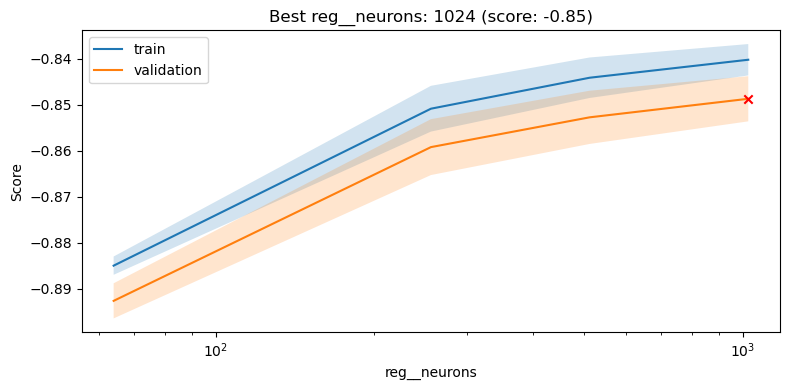

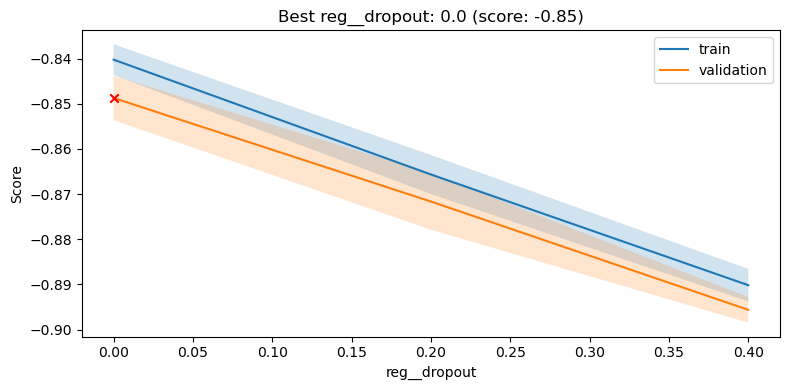

In [18]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__hidden": [2],
        "reg__neurons": [64, 256, 512, 1024],
        "reg__dropout": [0, 0.2, 0.4],
        "reg__l2": [0.001],
        "reg__epochs": [8],
    },
)

# We use a KerasRegressor to make a Keras model fit in the scikit estimator API
# We extended it to add support for pickling (cf shared.py)
# model_fun is the model builder function also implemented in shared.py because it needed to be shared with other notebooks.
reg = PickleableKerasRegressor(model_fun, shuffle=True, verbose=0)
model = eval_model("dnn_full", reg, grid, X_tv, y_tv, X_test, y_test, n_jobs=1)
hyperparam_graph(model, "reg__neurons", xlog=True)
hyperparam_graph(model, "reg__dropout", xlog=False)

Notes:
- It looks like the 2-hidden layer network performs similarly better than the 1-layer one.
We will therefore continue with this architecture.
- It seems that using dropout has a negative effect. We will set it to 0 in our next tests.

Let us continue with the learning rate and batch size.

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Total training time: 4141.99s
Mean fit time: 133.42s
----
Predicting train...
Prediction time: 8.92s
Score (train): 0.88
MAE (train): 0.79
RMSE (train): 1.4
----
Predicting test...
Prediction time: 4.0s
Score (test): 0.87
MAE (test): 0.81
RMSE (test): 1.46
Could not send push notification ([Errno 11001] getaddrinfo failed)


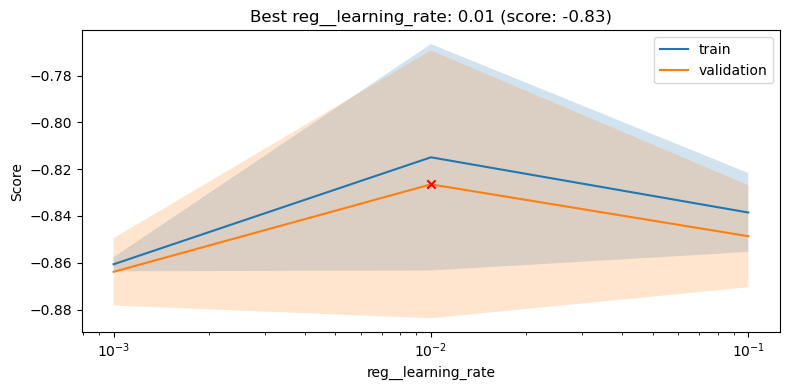

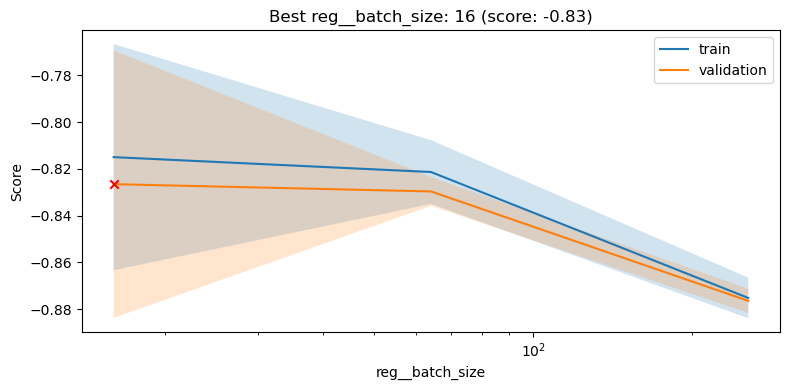

In [19]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__hidden": [2],
        "reg__neurons": [1000],
        "reg__dropout": [0],
        "reg__learning_rate": [0.001, 0.01, 0.1],
        "reg__batch_size": [16, 64, 256],
        "reg__l2": [0.001],
        "reg__epochs": [8],
    },
)

reg = PickleableKerasRegressor(model_fun, verbose=0)
model = eval_model("dnn_full", reg, grid, X_tv, y_tv, X_test, y_test, n_jobs=1)
hyperparam_graph(model, "reg__learning_rate", xlog=True)
hyperparam_graph(model, "reg__batch_size", xlog=True)

Notes:
- Increasing the learning rate seems to improve the performance with a maximum at 0.01.
- Decreasing the batch size improves the accuracy at the expense of computation time and overfitting.

We now fit the network with a large number of epochs and early stopping:

In [20]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__hidden": [2],
        "reg__neurons": [1000],
        "reg__dropout": [0],
        "reg__l2": [0.001],
        "reg__learning_rate": [0.01],
        "reg__batch_size": [16],
        "reg__epochs": [150],
        "reg__show_summary": [True],
    },
)

reg = HistoryKerasRegressor(
    model_fun,
    verbose=1,
    shuffle=True,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=6)],
)
model = eval_model(None, reg, grid, X_tv, y_tv, X_test, y_test, n_splits=1, n_jobs=1)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_287 (Dense)            (None, 1000)              23000     
_________________________________________________________________
dense_288 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_289 (Dense)            (None, 1)                 1001      
Total params: 1,025,001
Trainable params: 1,025,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
4051/4051 [==============================] - 32s 8ms/step - loss: 1.1375 - val_loss: 1.0524
Epoch 2/150
4051/4051 [==============================] - 31s 8ms/step - loss: 0.9776 - val_loss: 0.9112
Epoch 3/150
4051/4051 [==============================] - 31s 8ms/step - loss: 0.8498 - val_loss: 0.7985
E

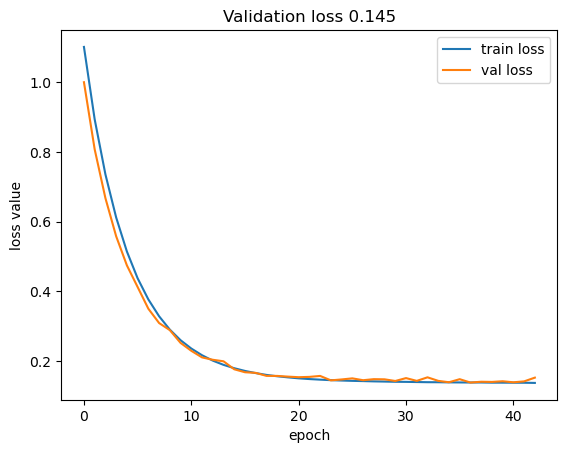

In [21]:
history = model.best_estimator_.regressor_.named_steps.reg.get_history()
plot_net_training_curves(history)

The model converged after 35 epochs and with very little overfitting.

We will now train the model one last time with the same parameters, but using a custom wrapper that is picklealable.
Because this wrapper won't work with the callbacks, we will run it for 35 epochs as it seems to be enough from the graph above.

In [25]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__hidden": [2],
        "reg__neurons": [1000],
        "reg__dropout": [0],
        "reg__l2": [0.001],
        "reg__learning_rate": [0.01],
        "reg__batch_size": [16],
        "reg__epochs": [35],
        "reg__show_summary": [False],
    },
)

reg = PickleableKerasRegressor(
    dnn_gen,
    verbose=1,
    shuffle=True,
    validation_split=0.2,
)
model = eval_model(
    "dnn_full", reg, grid, X_tv, y_tv, X_test, y_test, n_splits=1, n_jobs=1
)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/35
4051/4051 [==============================] - 37s 9ms/step - loss: 1.1400 - val_loss: 1.0787
Epoch 2/35
4051/4051 [==============================] - 36s 9ms/step - loss: 0.9791 - val_loss: 0.9209
Epoch 3/35
4051/4051 [==============================] - 36s 9ms/step - loss: 0.8513 - val_loss: 0.8063
Epoch 4/35
4051/4051 [==============================] - 38s 9ms/step - loss: 0.7439 - val_loss: 0.7055
Epoch 5/35
4051/4051 [==============================] - 36s 9ms/step - loss: 0.6533 - val_loss: 0.6234
Epoch 6/35
4051/4051 [==============================] - 36s 9ms/step - loss: 0.5765 - val_loss: 0.5490
Epoch 7/35
4051/4051 [==============================] - 36s 9ms/step - loss: 0.5115 - val_loss: 0.4947
Epoch 8/35
4051/4051 [==============================] - 37s 9ms/step - loss: 0.4566 - val_loss: 0.4398
Epoch 9/35
4051/4051 [==============================] - 35s 9ms/step - loss: 0.4097 - val_loss: 0.3982
Epoch 10/35
40

## Saving results

We recompute all the predictions and metrics for all the models on the test set and save them to disk for later use.

In [23]:
df = pd.read_csv(test_split_path)
df_pred = df[["GPP", "site", "date"]].set_index(["site", "date"])
df_pred.rename(columns={"GPP": "True GPP"}, inplace=True)

In [24]:
results = []

for model_name in model_list:
    print(f"Predicting {model_name}...")
    model = reload_model(model_name)
    _, pred_time_train, r2_train, mae_train, rmse_train = compute_metrics(
        model, X_tv, y_tv, "train", verbose=False
    )
    y_pred_test, pred_time_test, r2_test, mae_test, rmse_test = compute_metrics(
        model, X_test, y_test, "test", verbose=False
    )
    res = {
        "model": model_name,
        "pred_time_train": pred_time_train,
        "R2_train": r2_train,
        "MAE_train": mae_train,
        "RMSE_train": rmse_train,
        "pred_time_test": pred_time_test,
        "R2_test": r2_test,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
    }
    results.append(res)
    df_pred[model_name] = y_pred_test

# Persist the predictions
df_pred.to_csv(predictions_path)
print(df_pred.shape)

# Persist the metrics
results_df = (
    pd.DataFrame(results)
    # .drop_duplicates(subset=["model"], keep="last")
    .set_index("model")
)
results_df.to_csv(results_path)
results_df

Predicting baseline...
Predicting ridge_2p_rs...
Predicting knn_2p_pca...
Predicting ridge_full...
Predicting rf_full...
Predicting svr_full...
Predicting dnn_full...
3100/3100 [==============================] - 4s 1ms/step
(49599, 8)


,pred_time_train,R2_train,MAE_train,RMSE_train,pred_time_test,R2_test,MAE_test,RMSE_test
model,,,,,,,,
baseline,0.00,0.00,2.85,11.63,0.00,-0.00,2.84,11.66
ridge_2p_rs,0.06,0.61,1.52,4.58,0.03,0.60,1.54,4.68
knn_2p_pca,3.91,0.66,1.37,3.93,1.64,0.65,1.39,4.04
ridge_full,0.56,0.80,1.05,2.36,0.27,0.79,1.07,2.41
rf_full,1.58,0.87,0.82,1.52,0.69,0.86,0.86,1.67
svr_full,533.83,0.88,0.80,1.43,233.05,0.87,0.81,1.50
dnn_full,10.60,0.89,0.75,1.26,4.52,0.89,0.77,1.34
